In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Constantes
PATH_DATA = "../data/"
PATH_RAW = PATH_DATA + "raw/"
PATH_PROCESSED = PATH_DATA + "processed/"
PATH_EXTERNAL = PATH_DATA + "external/"
SEED = 123

pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 200)


In [2]:
df = pd.read_csv(PATH_PROCESSED + "X_train_preprocessed.csv", index_col=0)
display(df.head())
df.describe()

stop_words_french = pd.read_json(PATH_EXTERNAL + "stop_words_french.json")
print(stop_words_french.shape)
stop_words = []
stop_words.extend(stop_words_french[0].tolist())
stop_words.extend(["cm", "mm"])
print(len(stop_words))
stop_words[:10]

,productid,imageid,text,lemmes,len_text,len_lemmes,prdtypecode
0,3804725264,1263597046,pages de carnet personnalisées olivia dot grid...,page de carnet personnalisé olivia dot grid ca...,68,64,10
1,436067568,1008141237,journal des arts le n du l art et son marche s...,journal des art le ne du l art et son marche s...,177,172,2280
2,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,grand stylet ergonomique bleu gamepad nintendo...,731,732,50
3,50418756,457047496,peluche donald europe disneyland marionnette à...,peluche donald europe disneyland marionnette à...,52,52,1280
4,278535884,1077757786,la guerre des tuques luc a des idées de grande...,la guerre des tuques luc a des idée de grandeu...,203,212,2705


(496, 1)
498


['a', 'à', 'â', 'abord', 'afin', 'ah', 'ai', 'aie', 'ainsi', 'allaient']

In [3]:
data = df["lemmes"]
target = df["prdtypecode"]

# TfidfVectorizer

Voici les paramètres qui me semblent importants pour une classification de texte sur un corpus de 90 000 textes d'environ 500 caractères chacun:

- Le paramètre <b>ngram_range</b>, qui permet de générer des n-grams de caractères ou de mots. Pour un texte court, les unigrams et bigrams seraient probablement suffisants. 

- Le paramètre <b>max_features</b>, qui limite le nombre de features conservées. Étant donné le grand nombre de textes, il serait sage de limiter le nombre de features pour éviter le surapprentissage. 

- Le paramètre <b>min_df</b>, qui ignore les mots apparaissant dans trop peu de documents. Ici, on peut ignorer les mots n'apparaissant que dans quelques dizaines de textes sur 90 000.

- Le paramètre <b>max_df</b>, qui ignore les mots trop fréquents comme les mots vides. Avec des textes courts, de nombreux mots apparaitront dans une grande proportion des textes.

- Le paramètre <b>stop_words</b>, pour retirer les mots vides de la langue du corpus.

- Le paramètre <b>lowercase</b>, pour mettre tous les mots en minuscules et ainsi neutraliser les variations casse.

Voilà les principaux paramètres à prendre en compte pour cette tâche de classification de texte sur un grand corpus de textes courts.

In [4]:
tfidf_vect = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.5,
    min_df=0.0001,
    lowercase=True,
    stop_words=stop_words,
    max_features=10000,
)

data_vec = tfidf_vect.fit_transform(data)

# nombre de features
len(tfidf_vect.vocabulary_)

/Users/jeremyrava/anaconda3/envs/datascience_py3_11_7/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


10000

In [5]:
# Split data into training and testing sets
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    data_vec, target, test_size=0.2, random_state=SEED
)
print(X_train_vec.shape)
X_test_vec.shape

(67932, 10000)


(16984, 10000)

# SMOTE

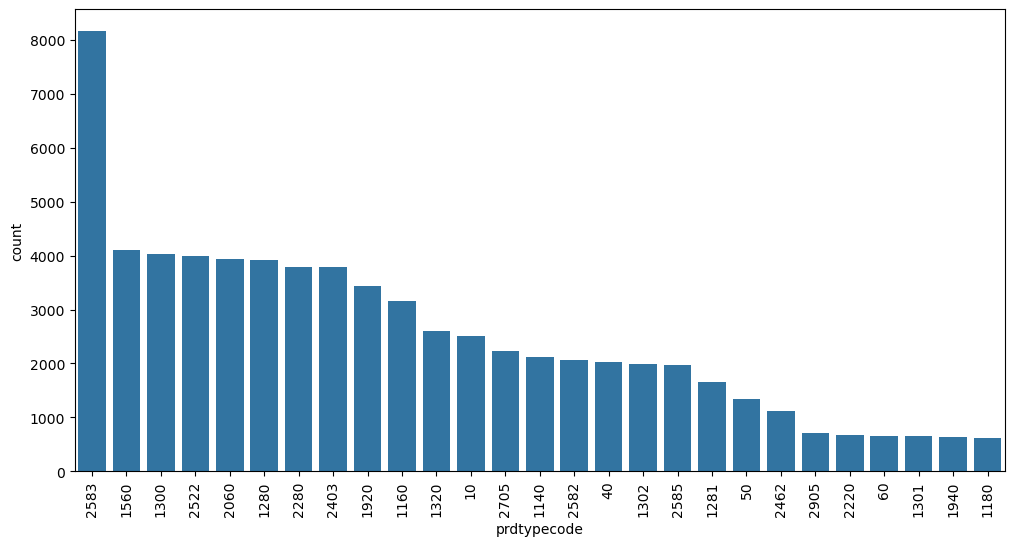

In [19]:
count = y_train.value_counts()
plt.figure(figsize=(12,6))
sns.barplot(count, order=count.index)
plt.xticks(rotation=90)
plt.show()

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

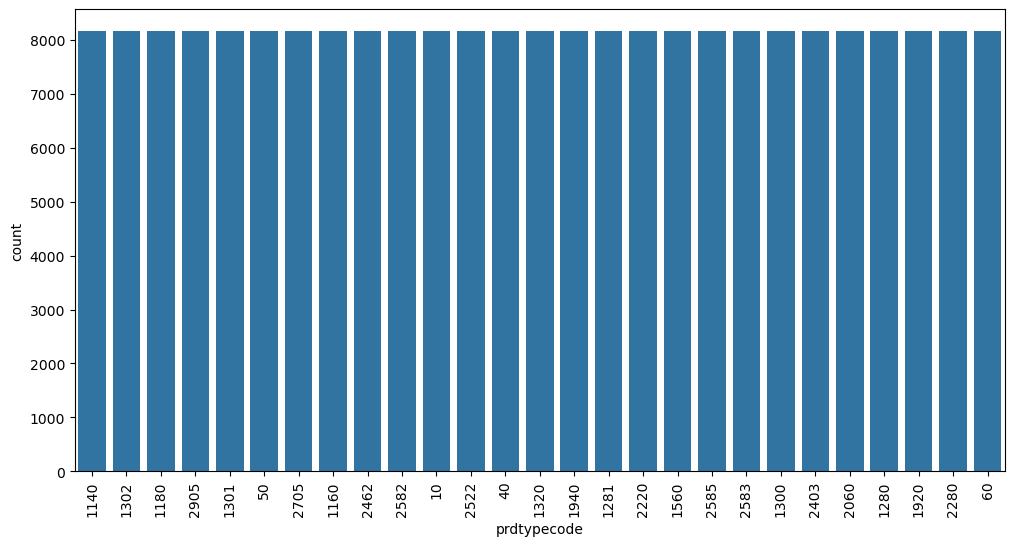

In [22]:
count = y_train.value_counts()
plt.figure(figsize=(12,6))
sns.barplot(count, order=count.index)
plt.xticks(rotation=90)
plt.show()

# Nearest Neighbors
Attention au nombre de features, prend beaucoup de temps si features important

le résultat ici est sur `max_features=2000`

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [8]:
# Define parameter grid
parameter_grid = {
    "n_neighbors": [3, 5, 7, 10],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto"],
}

# Create GridSearchCV object with defined parameter grid
grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(), param_grid=parameter_grid, cv=5
)

grid_search.fit(X_train_vec, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
0.3934831453134052


In [16]:
knn = KNeighborsRegressor(n_neighbors=3, weights="distance", algorithm="auto")

knn.fit(X_train_vec, y_train)

print("Score train :", knn.score(X_train_vec, y_train))
print("Score test :", knn.score(X_test_vec, y_test))

/Users/jeremyrava/anaconda3/envs/datascience_py3_11_7/lib/python3.11/site-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Score train : 0.5698129727061936
Score test : 0.3650525454508564


# SVC Ensemble Classifiers
Attention au nombre de features, prend beaucoup de temps si features important

le résultat ici est sur `max_features=2000`

In [10]:
from sklearn.svm import SVC

In [11]:
clf_svc = SVC()

clf_svc.fit(X_train_vec, y_train)

print("Score train :", clf_svc.score(X_train_vec, y_train))
print("Score test :", clf_svc.score(X_test_vec, y_test))

Score train : 0.7938232349997056
Score test : 0.7005416862929816


# Naive Bayes
D'après la page, les modèles de classification naïve bayésienne sont souvent bien adaptés aux données de classification de texte, car ils nécessitent peu de données d'entraînement et sont très rapides par rapport à d'autres méthodes plus sophistiquées. 

En particulier, le modèle "Multinomial Naive Bayes" est l'un des deux modèles naïfs bayésiens classiques utilisés pour la classification de texte, car il suppose une distribution multinomiale des données, ce qui convient bien aux vecteurs de comptage de mots qui représentent généralement les données textuelles. 

Le modèle "Complement Naive Bayes" est également mentionné comme s'adaptant particulièrement bien aux ensembles de données déséquilibrés, en utilisant des statistiques du "complément" de chaque classe pour calculer les poids du modèle.

Donc en résumé, les modèles de classification naïve bayésienne comme "Multinomial Naive Bayes" et "Complement Naive Bayes" sont souvent les mieux adaptés pour la classification de texte avec des entrées textuelles et une cible de classification.

#### Peu importe le nombre de `max_features`, le résultat est instantané

In [23]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB

In [24]:
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train_vec, y_train)

print("Score train :", clf_mnb.score(X_train_vec, y_train))
print("Score test :", clf_mnb.score(X_test_vec, y_test))

Score train : 0.8133812401328325
Score test : 0.7518252472915685


In [25]:
clf_cnb = ComplementNB()
clf_cnb.fit(X_train_vec, y_train)

print("Score train :", clf_cnb.score(X_train_vec, y_train))
print("Score test :", clf_cnb.score(X_test_vec, y_test))

Score train : 0.7273304661839693
Score test : 0.6902967498822421


# Validation croisée imbriquée (Nested CV)
Pas encore testé (ne fonctionne pas actuellement)

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
lr = LogisticRegression(random_state=22, max_iter=2000)
rf = RandomForestClassifier(random_state=22)
svc = SVC(random_state=22)

param_grid_lr = {"solver": ["liblinear", "lbfgs"], "C": np.logspace(-4, 2, 9)}

param_grid_rf = [
    {
        "n_estimators": [10, 50, 100, 250, 500, 1000],
        "min_samples_leaf": [1, 3, 5],
        "max_features": ["sqrt", "log2"],
    }
]

param_grid_svc = [
    {"kernel": ["rbf"], "C": np.logspace(-4, 4, 9), "gamma": np.logspace(-4, 0, 4)},
    {"kernel": ["linear"], "C": np.logspace(-4, 4, 9)},
]

In [ ]:
gridcvs = {
    "lr": GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=3, refit=True),
    "rf": GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, refit=True),
    "svc": GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=3, refit=True),
}

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}
for k, v in gridcvs.items():
    outer_scores[k] = cross_val_score(v, X_train, y_train, cv=skf)
    print(
        f"{k}: outer accuracy {100*outer_scores[k].mean():.2f} +/- {100*outer_scores[k].std():.2f}"
    )

In [ ]:
final_clf = gridcvs["rf"]
final_clf.fit(X_train, y_train)

print(f"Best Parameters: {final_clf.best_params_}")

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f"Training Accuracy: {100*train_acc:.2f}")
print(f"Test Accuracy: {100*test_acc:.2f}")